<a href="https://colab.research.google.com/github/yumkim1016/TP1/blob/main/Binary_data_sumup_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[이진분류모델] 천체의 펄서(Pulsar) 판정하기

## 0. 들어가기에 앞서..
펄서스타란, 1968년 영국의 천문학자 버넬과 휴이시가 발견한 **강한 자기장을 가진 채 빠르게 회전하는 중성자별**로 추정됩니다. 매우 빠르게 회전하면서 전파를 방출하며,  맥동전파원()이라고 하여 1.5ms~8.5sec 정도 주기로 신호의 강도가 변화되어 규칙적으로 깜빡이게되는데, 이때문에 우주의 등대라는 별명을 갖게되었습니다.       
      
펄서의 여부는 망원경으로는 식별이 어려워 전파 망원경으로 관측하고있으며, 전파 망원경에 잡히는 많은 천체 중 펄서 후보를 추정하면 소수 후보에 대한 집중적인 정밀관측이 가능해지기 때문에 반드시 판정과정이 필요합니다.    
     
이에 우리는 관련된 특성들을 가지고 펄서의 여부를 판정하는 모델을 개발하였으며, 이번 프로젝트로 기존 모델의 성능을 고도화 시켰습니다.




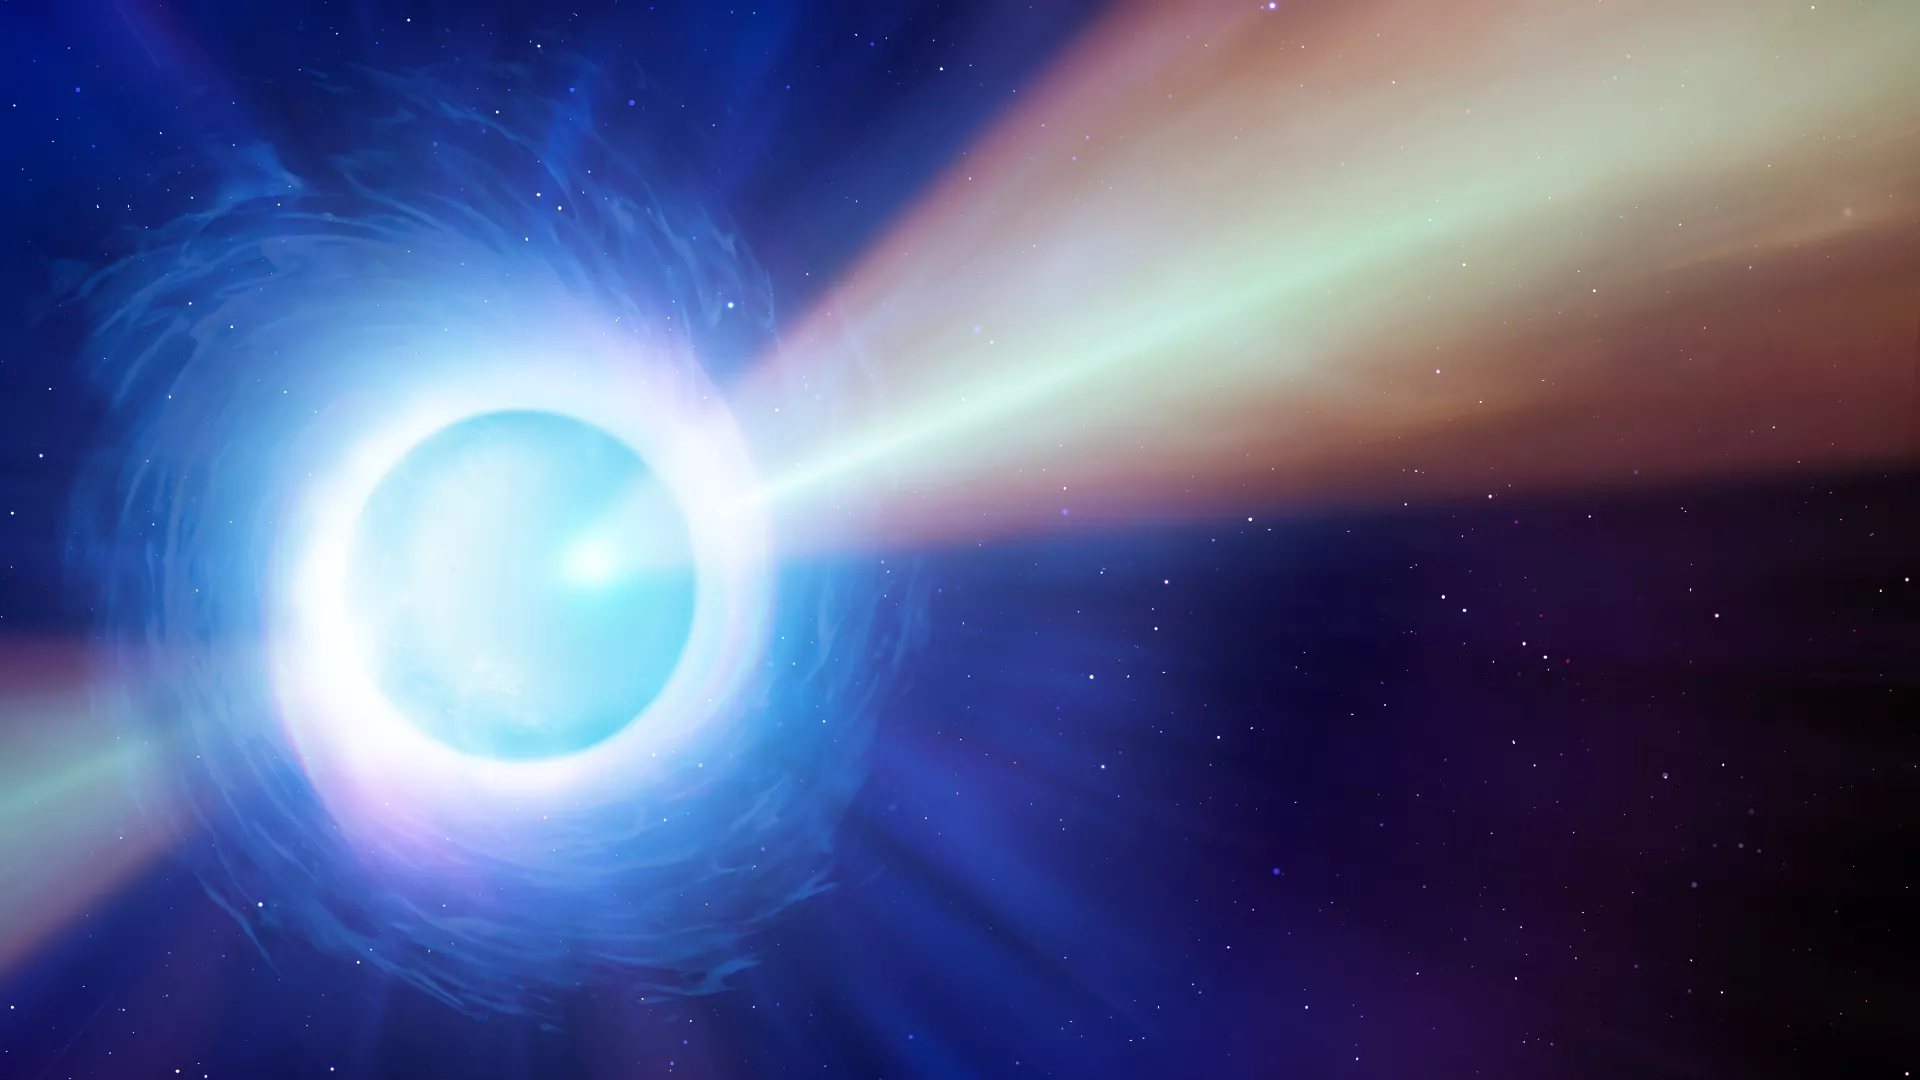

## 1. 데이터 소개
- 데이터 수: 전처리 전 17,898
  - 매우 불균형한 데이터(0 비펄서 16,259 / 1 펄서 1,639)
- 특성(feature): 8개 / dtypes: float
  - Mean of the integrated profile: 통합 프로필의 평균값
  - Standard deviation of the integrated profile: 통합 프로필의 표준 편차
  - Excess kurtosis of the integrated profile: 통합 프로필의 과잉 첨도     
    - 과잉첨도 = 첨도 - 예상 정규 분포의 첨도 값      
    - 첨도: 데이터 분포의 꼬리 부분의 두께와 중앙 부분의 뾰족함을 측정하는 통계적 개념. 
      - 정규 분포 (Normal Distribution): 첨도가 0인 경우, 데이터 분포는 대략적으로 정규 분포를 따름.
      - 얇은 꼬리 (Leptokurtic Distribution): 첨도가 0보다 큰 경우, 데이터 분포는 뾰족한 모양. 이는 데이터가 중앙에 집중되어 있고, 극단적인 값들이 상대적으로 더 많이 발생한다는 것을 의미함.
      - 두꺼운 꼬리 (Platykurtic Distribution): 첨도가 0보다 작은 경우, 데이터 분포는 더 평평한 모양을 가지며, 이는 데이터가 중앙에 덜 집중되어 있고, 극단적인 값들이 상대적으로 더 적게 발생한다는 것을 의미함.
  - Skewness of the integrated profile: 통합 프로필의 비대칭도
  - Mean of the DM-SNR curve: DM-SNR 곡선의 평균값
  - Standard deviation of the DM-SNR curve: DM-SNR 곡선의 표준 편차
  - Excess kurtosis of the DM-SNR curve: DM-SNR 곡선의 과잉 첨도
  - Skewness of the DM-SNR curve: DM-SNR 곡선의 비대칭도       
\* DM-SNR: "Dispersion Measure-Signal-to-Noise Ratio"의 약자. 천문학적 신호를 분석할 때 사용되는 척도로, 해당 신호의 디스퍼젼 메져와 신호 대 잡음 비율의 조합을 의미        
- 타겟(target): 1개 / dtype: int
  - target_class(0: 비펄서, 1: 펄서)

In [5]:
!pip3 install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import eli5
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('binary_classification_data.csv')

In [8]:
print("[데이터 shape]", df.shape, "\n[데이터 info]")
df.info()

[데이터 shape] (17898, 9) 
[데이터 info]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), i

## 2. 데이터 전처리 및 EDA

### 기본검사

In [9]:
# 불균형 검사(분류 모델시 반드시 확인)
df['target_class'].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [10]:
# 결측치 검사
df.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [11]:
# 중복데이터 검사
df.duplicated().sum()

0

In [12]:
# 통계치 검사
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


### Outlier Checking / Deleting

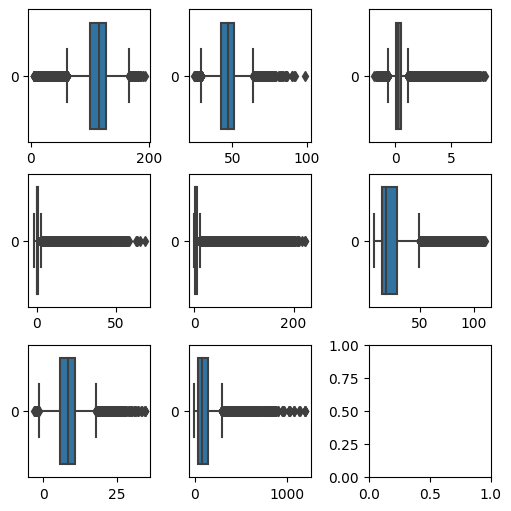

In [13]:
# 각 feature 분포확인

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5,5), constrained_layout=True)

for i, feature in enumerate(df.columns[:-1]): # 타겟제외
    sns.boxplot(df[feature], ax=ax[int(i/3),int(i%3)], orient='h')
plt.show()

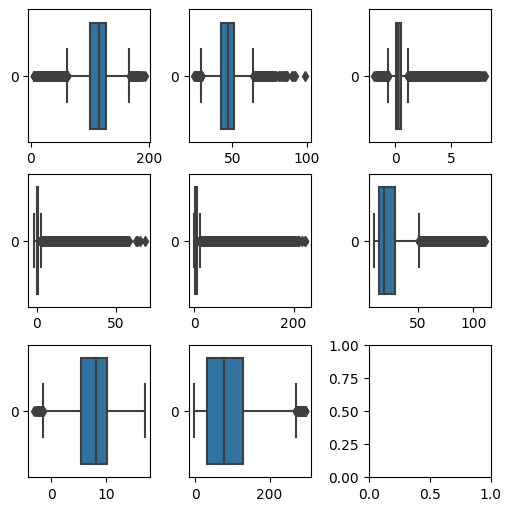

In [14]:
# 아웃라이어 제거 함수 정의
def remove_outliers(data, feature, fence_factor=1.5):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)
  IQR = Q3 - Q1
  lower_fence = Q1 - fence_factor * IQR
  upper_fence = Q3 + fence_factor * IQR
  filtered_data = data[(data[feature] >= lower_fence) & (data[feature] <= upper_fence)]
  return filtered_data

# 아웃라이어 제거
for column in df.columns[:-1]:
  df2 = remove_outliers(df, column, fence_factor=1.5)

# 각 feature 분포확인
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5,5), constrained_layout=True)
for i, feature in enumerate(df2.columns[:-1]): # 타겟제외
    sns.boxplot(df2[feature], ax=ax[int(i/3),int(i%3)], orient='h')
plt.show()

In [15]:
# Outlier 제거 후 shape변화
print("[기존]\nshape:", df.shape, "\ntarget class 분류:")
print(df['target_class'].value_counts())
print("\n[Outlier 제거 후]\nshape:", df2.shape, "\ntarget class 분류:")
print(df2['target_class'].value_counts())
print('--------------------------------')
print('데이터 개수 및 비율 변화 큰 차이 없음, 계속 진행 가능')

[기존]
shape: (17898, 9) 
target class 분류:
0    16259
1     1639
Name: target_class, dtype: int64

[Outlier 제거 후]
shape: (16997, 9) 
target class 분류:
0    15367
1     1630
Name: target_class, dtype: int64
--------------------------------
데이터 개수 및 비율 변화 큰 차이 없음, 계속 진행 가능


In [16]:
# 재정의
df = df2

### Normalization and Standardization

In [17]:
features = df.columns[:-1]
target = df.columns[-1]

X = df[features]
y = df[target]

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

def Scaler(X_train, X_val, X_test):
  X_train_S = pd.DataFrame(np.squeeze(pipeline.fit_transform(X_train)), columns=features, index=X_train.index)
  X_val_S = pd.DataFrame(np.squeeze(pipeline.transform(X_val)), columns=features, index=X_val.index)
  X_test_S = pd.DataFrame(np.squeeze(pipeline.transform(X_test)), columns=features, index=X_test.index)
  return X_train_S, X_val_S, X_test_S

In [18]:
# 데이터 저장
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [19]:
# Machine Learning 모델을 위한 Standard Scaler 데이터1:
pipeline = Pipeline([('scaler', StandardScaler())])

X_train_ML, X_val_ML, X_test_ML = Scaler(X_train, X_val, X_test)

In [20]:
# 데이터 저장

X_train_ML.to_csv('X_train_ML.csv', index=False)
X_val_ML.to_csv('X_val_ML.csv', index=False)
X_test_ML.to_csv('X_test_ML.csv', index=False)

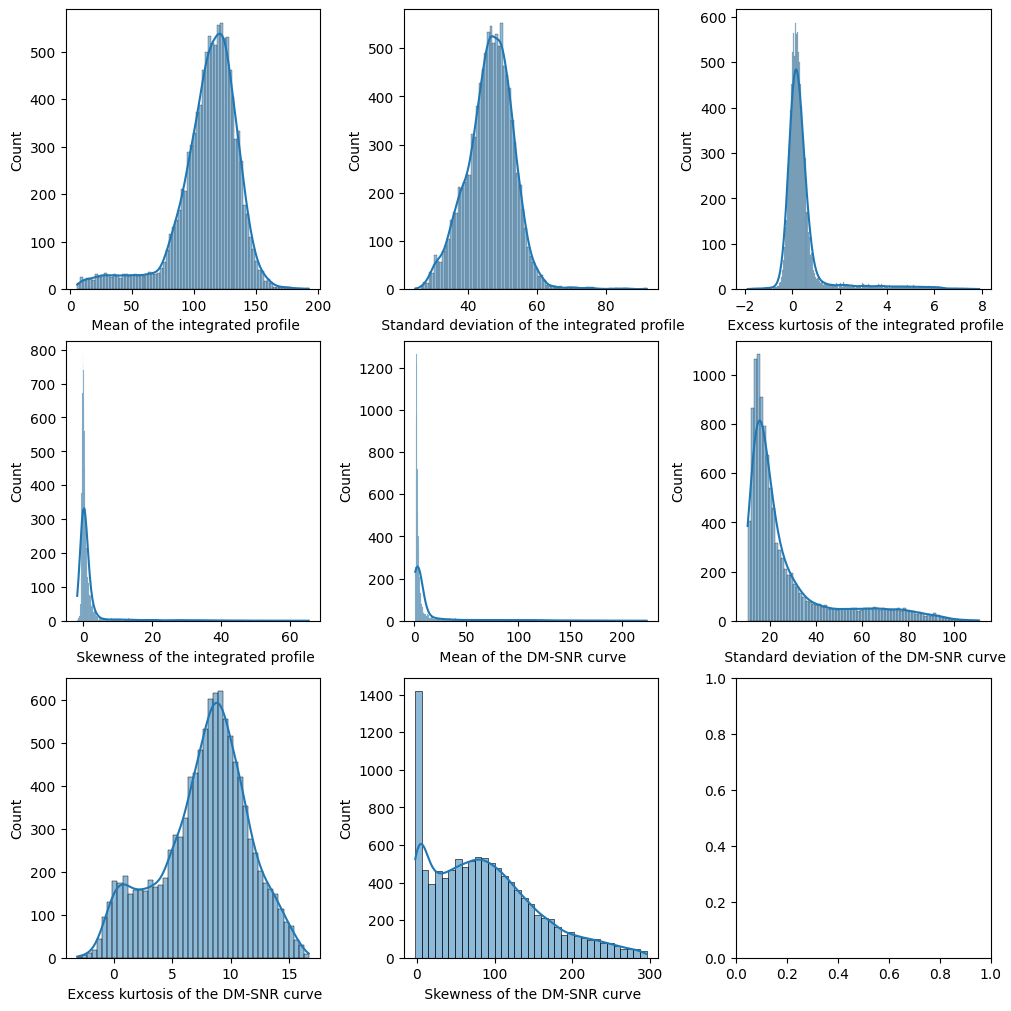

In [21]:
# Scaling 전, 후 분포값 비교

# Scaling 전:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10), constrained_layout=True)

for i, feature in enumerate(X_train.columns):
    sns.histplot(X_train[feature], ax=ax[int(i//3),int(i%3)], kde=True)
plt.show()

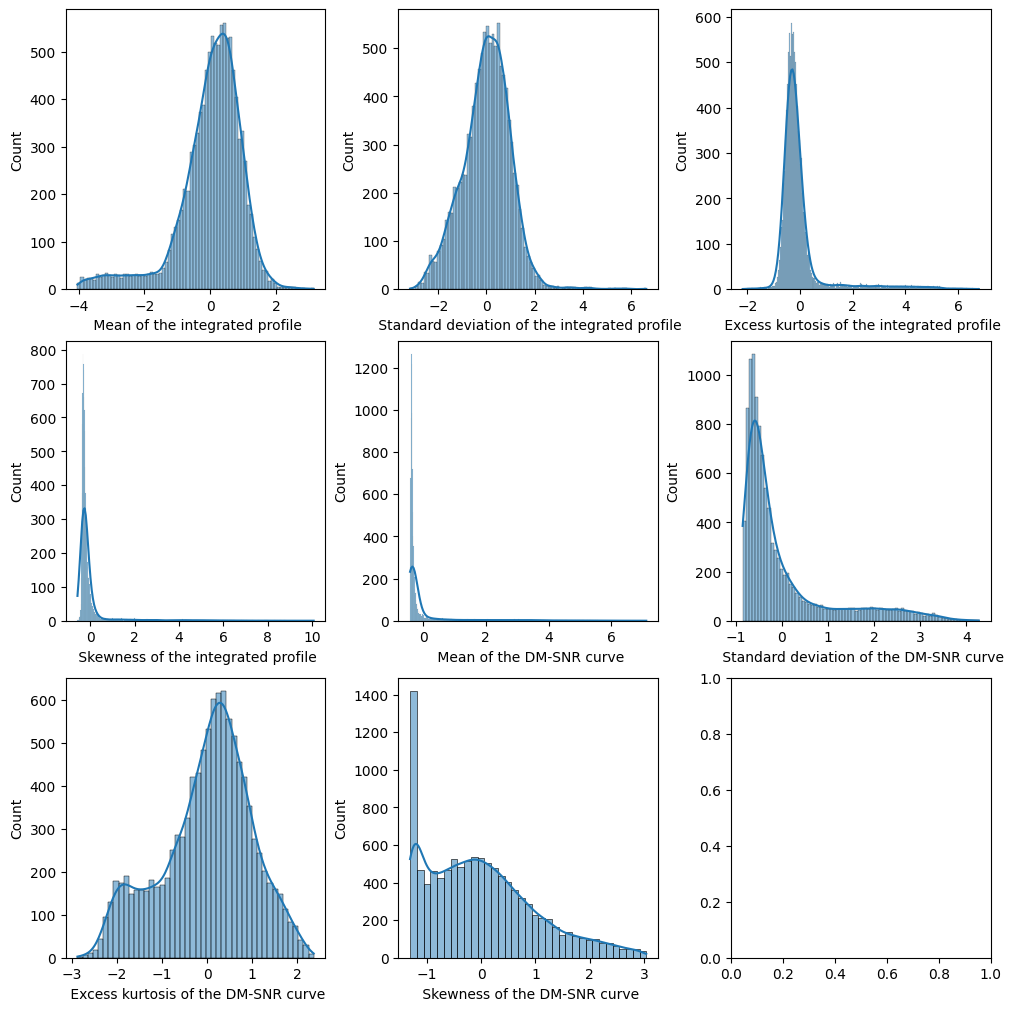

In [22]:
# Scaling 후:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10), constrained_layout=True)

for i, feature in enumerate(X_train_ML.columns):
    sns.histplot(X_train_ML[feature], ax=ax[int(i//3),int(i%3)], kde=True)
plt.show()

In [23]:
# Deeplearning model을 위한 MinMax + Standard Scaler 조합 데이터2:
pipeline = Pipeline([('normalizer', MinMaxScaler()),
                     ('scaler', StandardScaler())])

X_train_DL, X_val_DL, X_test_DL = Scaler(X_train, X_val, X_test)

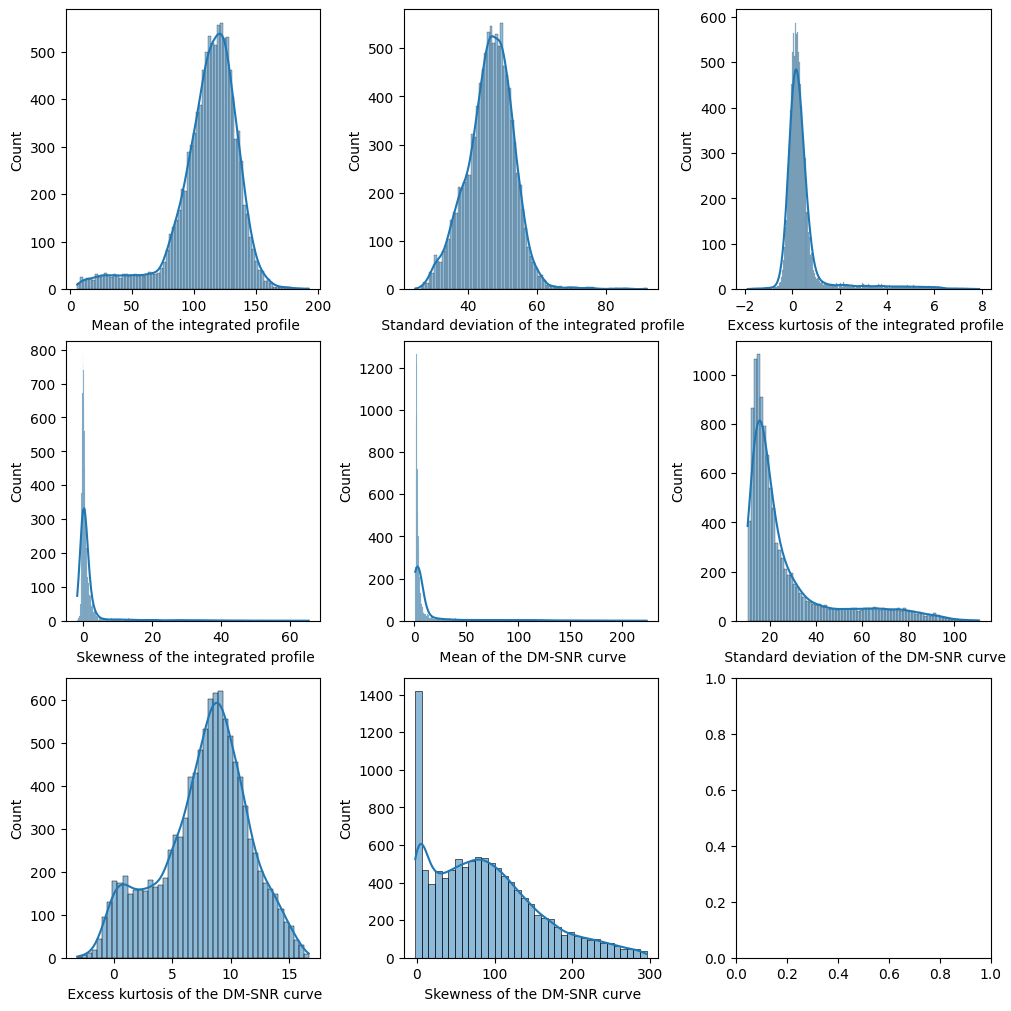

In [24]:
# Normalizing + Scaling 전, 후 분포값 비교

# Normalizing + Scaling 전:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10), constrained_layout=True)

for i, feature in enumerate(X_train.columns):
    sns.histplot(X_train[feature], ax=ax[int(i//3),int(i%3)], kde=True)
plt.show()

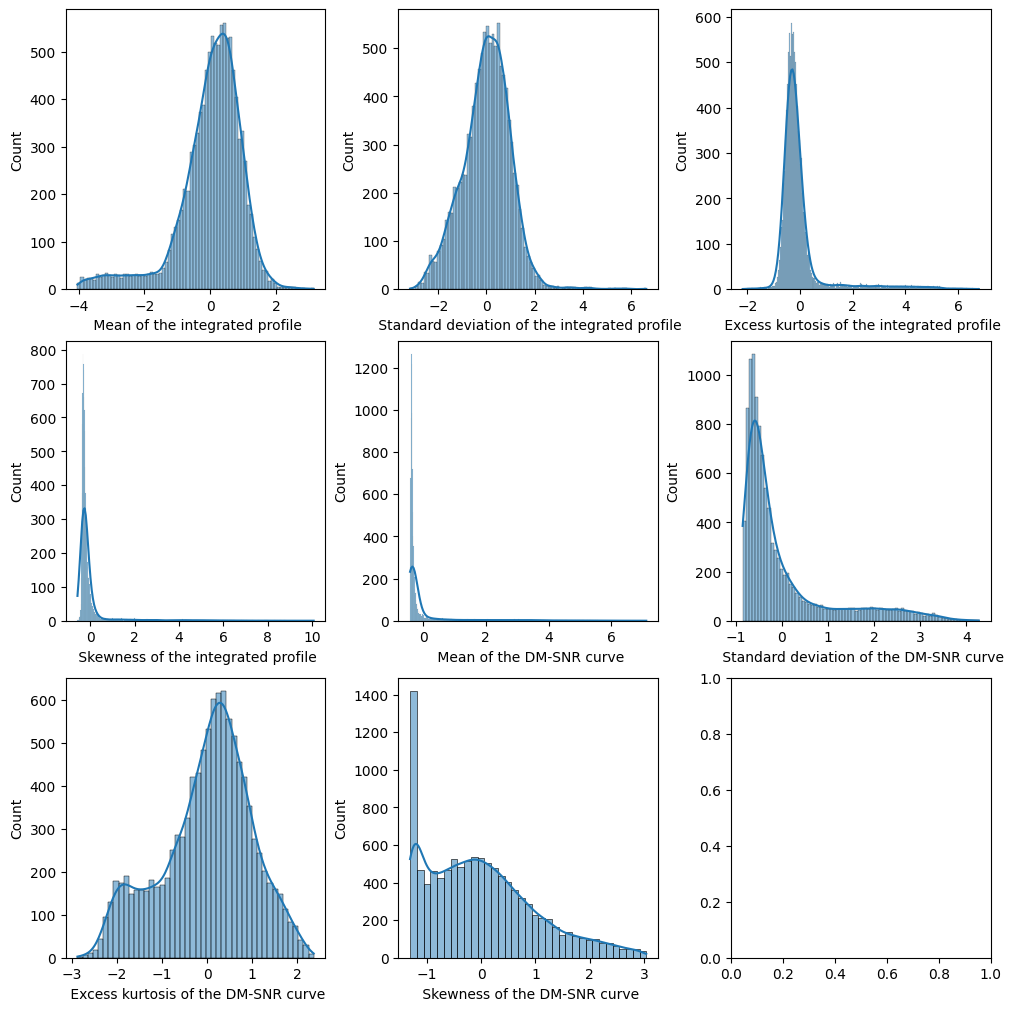

In [25]:
# Normalizing + Scaling 후:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10), constrained_layout=True)

for i, feature in enumerate(X_train_DL.columns):
    sns.histplot(X_train_DL[feature], ax=ax[int(i//3),int(i%3)], kde=True)
plt.show()

In [26]:
# 데이터 저장
X_val_DL = pd.DataFrame(np.squeeze(X_val_DL), columns=features, index=X_val.index)
X_test_DL = pd.DataFrame(np.squeeze(X_test_DL), columns=features, index=X_test.index)

X_val_DL.to_csv('X_val_DL.csv', index=False)
X_test_DL.to_csv('X_test_DL.csv', index=False)

### OverSampling (SMOTE)



In [27]:
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))

In [28]:
y_train.value_counts()

0    9834
1    1043
Name: target_class, dtype: int64

In [29]:
# Deeplearning model을 위한 MinMax+Standard 데이터에 SMOTE 업데이트
X_train_DL, y_train_DL = SMOTE(random_state=42).fit_resample(X_train_DL,y_train)
count_and_plot(y_train_DL)

Class=0, n=9834 (50.000%)
Class=1, n=9834 (50.000%)


In [30]:
# 데이터 저장
X_train_DL.to_csv('X_train_DL.csv', index=False)
y_train_DL.to_csv('y_train_DL.csv', index=False)

### 전처리 후 데이터 확인

In [31]:
# ML data
print('ML data shape: ', X_train_ML.shape)
print('ML data target: ', y_train.value_counts())
# DL data
print('DL data shape: ', X_train_DL.shape)
print('DL data target: ', y_train_DL.value_counts())

ML data shape:  (10877, 8)
ML data target:  0    9834
1    1043
Name: target_class, dtype: int64
DL data shape:  (19668, 8)
DL data target:  0    9834
1    9834
Name: target_class, dtype: int64


### Feature Importance / Permutation Importance

In [32]:
# Feature Importance

features = X_train
target = y_train

# 랜덤 포레스트 분류기 모델 생성
rf = RandomForestClassifier(random_state=42)
rf.fit(features, target)

# Feature importance 계산
importances = rf.feature_importances_

# 결과 출력
for feature, importance in zip(features.columns, importances):
  print(f'{feature}: {importance}')

 Mean of the integrated profile: 0.1486708085352927
 Standard deviation of the integrated profile: 0.04817804704797337
 Excess kurtosis of the integrated profile: 0.37575770860808994
 Skewness of the integrated profile: 0.2133743907798322
 Mean of the DM-SNR curve: 0.06393941810571503
 Standard deviation of the DM-SNR curve: 0.06813403110706864
 Excess kurtosis of the DM-SNR curve: 0.03725135126734591
 Skewness of the DM-SNR curve: 0.04469424454868232


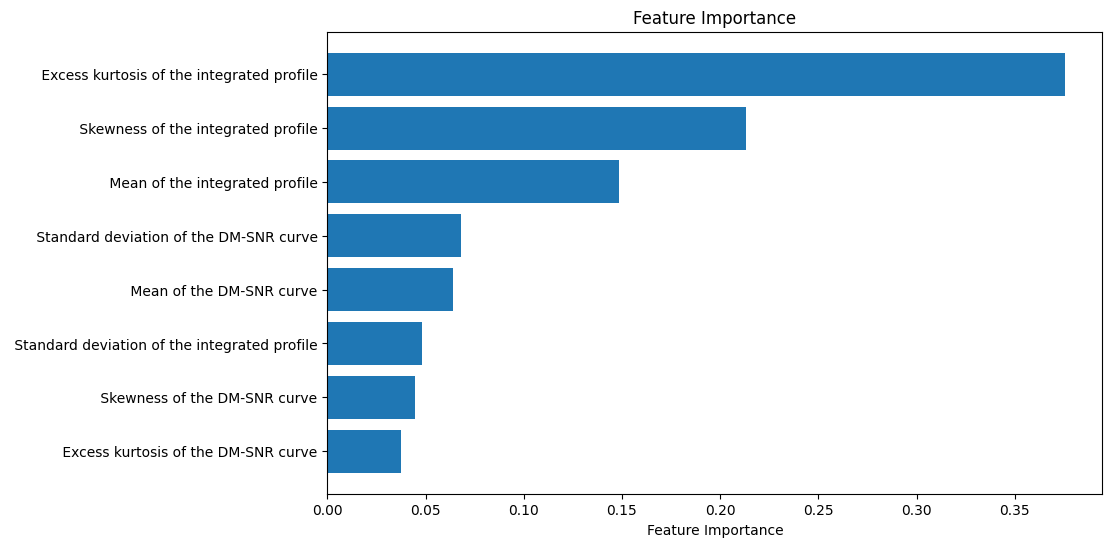

In [33]:
# bar plot으로 결과 시각화, 높은순서대로 표시

feature_names = features.columns
sorted_indices = np.argsort(importances)
pos = np.arange(sorted_indices.shape[0]) + 0.5

plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_indices], align='center')
plt.yticks(pos, feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

In [34]:
# feature importance는 high cardinality에 취약하기때문에, high cardinality로 인한 결과인지 확인이 꼭 필요하다

for columns in X_train.columns:
  cardinality = X_train[columns].nunique()
  print(f"특성 '{columns}'의 고유한 값의 수: {cardinality}")

특성 ' Mean of the integrated profile'의 고유한 값의 수: 6638
특성 ' Standard deviation of the integrated profile'의 고유한 값의 수: 10861
특성 ' Excess kurtosis of the integrated profile'의 고유한 값의 수: 10876
특성 ' Skewness of the integrated profile'의 고유한 값의 수: 10877
특성 ' Mean of the DM-SNR curve'의 고유한 값의 수: 6484
특성 ' Standard deviation of the DM-SNR curve'의 고유한 값의 수: 10877
특성 ' Excess kurtosis of the DM-SNR curve'의 고유한 값의 수: 10877
특성 ' Skewness of the DM-SNR curve'의 고유한 값의 수: 10877


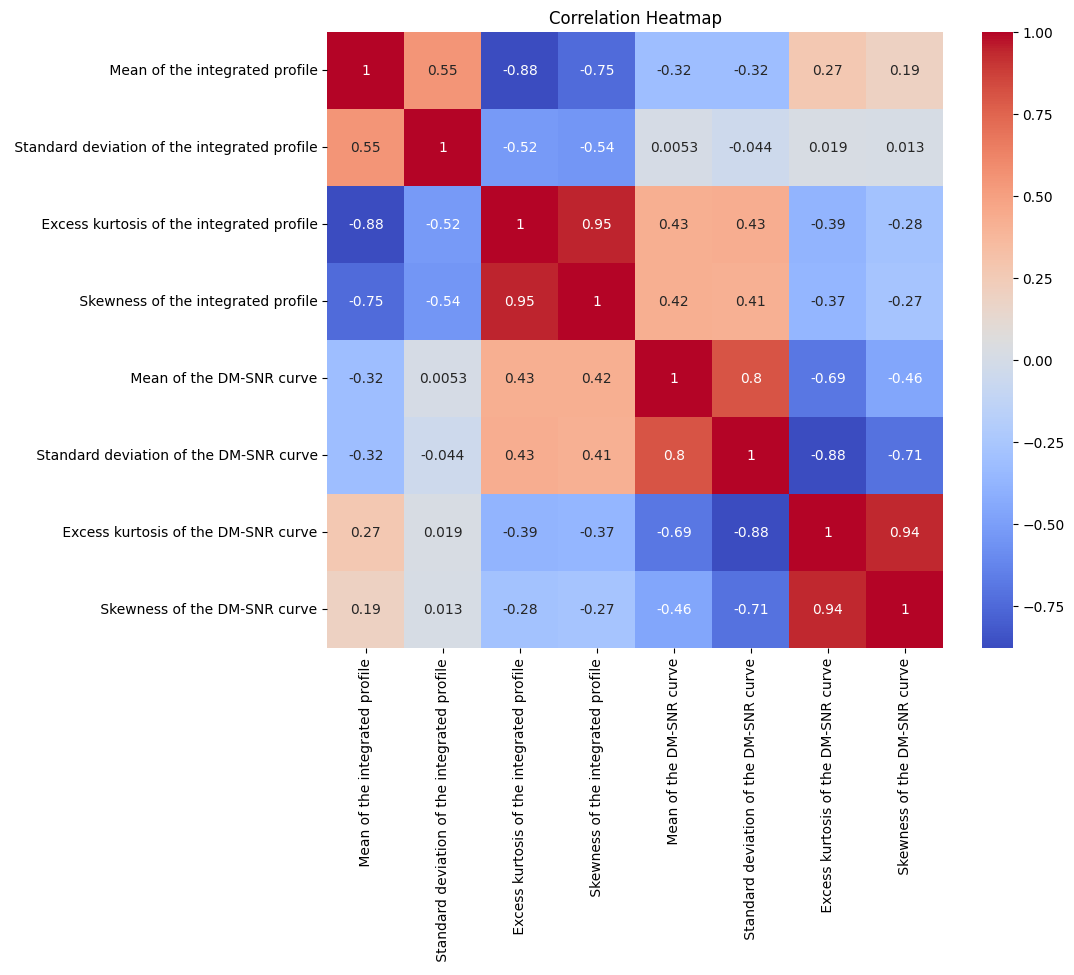

In [35]:
# Heatmap

# 상관관계 계산
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [36]:
# 눈에 띄게 떨어지는 중요도는 없음, drop 진행 X

In [37]:
# Permutation Importance

# 모델 훈련 및 예측
rf.fit(X_train, y_train)

# Permutation Importances 계산
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

# 결과 출력
importance_scores = result.importances_mean
feature_names = X_train.columns

for feature_name, importance_score in zip(feature_names, importance_scores):
    print(f"{feature_name}: {importance_score}")

feature_names = X_train.columns.tolist()

eli5.show_weights(
    rf, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로
)

 Mean of the integrated profile: 0.0108026110140664
 Standard deviation of the integrated profile: 0.008485795715730438
 Excess kurtosis of the integrated profile: 0.15305690907419325
 Skewness of the integrated profile: 0.008844350464282436
 Mean of the DM-SNR curve: 0.007051576721522479
 Standard deviation of the DM-SNR curve: 0.011087616070607709
 Excess kurtosis of the DM-SNR curve: 0.005773650822837195
 Skewness of the DM-SNR curve: 0.007860623333639783


Weight,Feature
0.3758 ± 0.6233,Excess kurtosis of the integrated profile
0.2134 ± 0.5292,Skewness of the integrated profile
0.1487 ± 0.4502,Mean of the integrated profile
0.0681 ± 0.1832,Standard deviation of the DM-SNR curve
0.0639 ± 0.1815,Mean of the DM-SNR curve
0.0482 ± 0.1148,Standard deviation of the integrated profile
0.0447 ± 0.1193,Skewness of the DM-SNR curve
0.0373 ± 0.1046,Excess kurtosis of the DM-SNR curve


### PCA

In [38]:
# 모든 독립변수 개수(8개) 만큼 주성분 개수 설정해서 분석하기
pca = PCA(n_components=8)
pca_array = pca.fit_transform(X_train)
pca_df = pd.DataFrame(pca_array, index=X_train.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
11473,-111.370759,29.099878,71.679827,5.432196,-0.627671,-2.277481,-0.006084,0.009025
15340,-14.214468,-10.184590,-14.216455,5.945830,5.319664,-0.626115,0.024306,-0.096055
1447,47.832164,13.075353,-16.031696,0.876794,-1.069027,-3.386143,-0.678998,0.064721
10662,-49.138492,-22.773776,-6.500619,0.863671,4.535149,0.181163,0.058956,0.075669
9955,6.502430,-27.677104,15.171522,1.094138,-2.997094,2.598973,-0.916375,0.050626


In [39]:
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산비율(고윳값)':pca.explained_variance_, 
                       '기여율': pca.explained_variance_ratio_}, index = np.array([f"pca{num+1}" for num in range(pca.n_components)]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산비율(고윳값),기여율,누적기여율
pca1,5172.113858,0.771227,0.771227
pca2,887.973680,0.132408,0.903635
pca3,534.314517,0.079673,0.983307
pca4,66.207272,0.009872,0.993180
pca5,32.425634,0.004835,0.998015
pca6,12.975916,0.001935,0.999950
pca7,0.299510,0.000045,0.999994
pca8,0.037582,0.000006,1.000000


In [40]:
# 기여율이 평탄해지는 pca3으로 진행
pca = PCA(n_components=3)
pca_array = pca.fit_transform(X_train)
pca_df = pd.DataFrame(pca_array, index=X_train.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2,pca3
11473,-111.370759,29.099878,71.679827
15340,-14.214468,-10.184590,-14.216455
1447,47.832164,13.075353,-16.031696
10662,-49.138492,-22.773776,-6.500619
9955,6.502430,-27.677104,15.171522


In [41]:
pca_df['target_class'] = df['target_class']

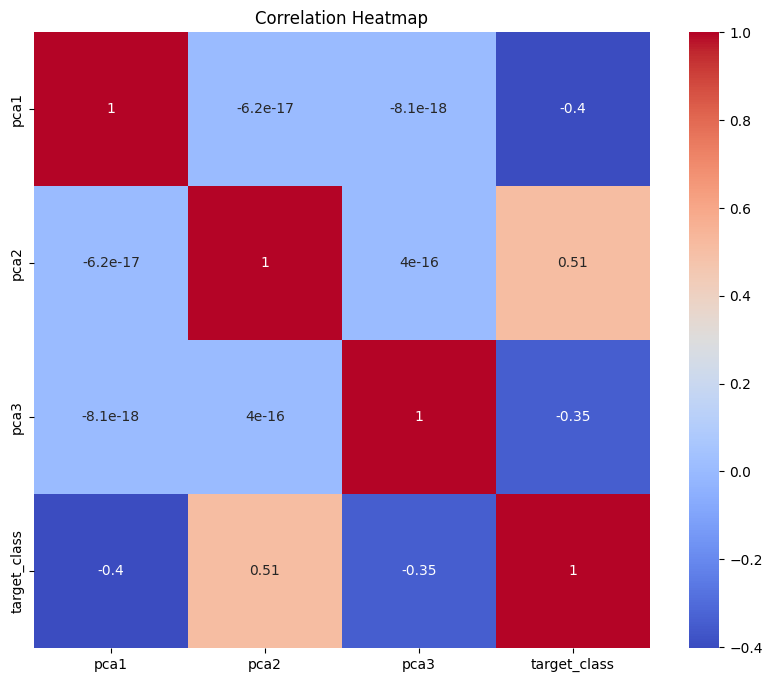

In [42]:
# Heatmap

# 상관관계 계산
features = pca_df
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

## 2. 모델링

### BEST ML(Basic Data + Scaler with GridSearchCV)
 로지스틱 회귀

In [50]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Dropout
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

In [44]:
# 성능 평가 관련 함수 정의

def cf_maxtix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
     

def get_clf_eval(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 Score: {f1:.4f}')

In [45]:
pipe = Pipeline([("classification", LogisticRegression())])
param_grid = {'classification__penalty': ['l1', 'l2', 'elasticnet', None],
              'classification__C': [0.5, 1, 3, 5],
              'classification__max_iter':[100, 150, 200]}

grid = GridSearchCV(pipe, param_grid, cv=5)

start = time.time()
grid.fit(X_train_ML, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")
print(f"최적의 매개변수: {grid.best_params_}")

모델 학습 시간: 6.636422395706177
최적의 매개변수: {'classification__C': 0.5, 'classification__max_iter': 100, 'classification__penalty': None}


In [46]:
y_pred = grid.best_estimator_.predict(X_test_ML)

In [47]:
print(f"train: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train: 0.9782
test: 
정확도: 0.9812, 정밀도: 0.9549, 재현율: 0.8436, F1 Score: 0.8958


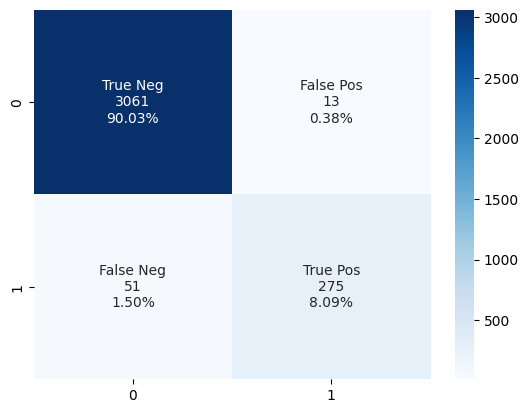

In [48]:
cf_maxtix(y_test, y_pred)

### BEST DL
- 모델 구성:
  - 은닉층 6개 + 출력층 1개 + 입력층 1개 = 8개
  - 가중치 부여
  - 활성화 함수 relu / 출력층 sigmoid
  - Batch Normalization, Drop out: 성능/속도 상승 및 과적합 방지용
  - Early Stopping: val_acc 기준으로 적용(setting epoch 1,000)

In [56]:
class_weight1 = {0: 1., 1: (len(y_train_DL) / sum(y_train_DL))}

def custom_opt(n):
    opt = tf.keras.optimizers.Adam(learning_rate=n)
    return opt

# 변수 리스트 생성
func = 'relu'
batch = 64
i = 0.003

metrics_lst = []


# 모델 구현
model = Sequential()
model.add(Dense(256, activation=func, input_shape=(X_train_DL.shape[1],)))
model.add(BatchNormalization()) # 배치 정규화 추가
model.add(Dropout(0.2))  # Dropout 추가
model.add(Dense(128, activation=func))
model.add(BatchNormalization()) # 배치 정규화 추가
model.add(Dropout(0.2))  # Dropout 추가              
model.add(Dense(64, activation=func))
model.add(Dense(32, activation=func))
model.add(Dense(16, activation=func))
model.add(Dense(8, activation=func))
model.add(Dense(8, activation=func))
model.add(Dense(1, activation='sigmoid')) # 출력층을 sigmoid , 또는 relu사용 가능

# 모델 컴파일
model.compile(optimizer=custom_opt(i), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping 기능 추가
early_stopping = EarlyStopping(patience=10, monitor='val_accuracy')
start_time = time.time()


# 모델 적용
model.fit(X_train_DL, y_train_DL, epochs=1000, batch_size=batch, validation_data=(X_val_DL, y_val), callbacks=[early_stopping], class_weight=class_weight1, verbose = 0)

end_time = time.time()
long_time = end_time - start_time


# 모델 평가
y_pred = model.predict(X_train_DL)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
metrics_lst.append(f1_score(y_train_DL, y_pred_binary))
metrics_lst.append(precision_score(y_train_DL, y_pred_binary))
metrics_lst.append(recall_score(y_train_DL, y_pred_binary))
mean_met = np.mean(metrics_lst)

print("train_loss, train_accuracy")
train_loss, train_cc = model.evaluate(X_train_DL, y_train_DL, verbose = 2)

print("val_loss, val_accuracy")
val_loss, val_acc = model.evaluate(X_val_DL, y_val, verbose = 2)

print("걸린시간 :", long_time)

print("=== train set ===")
print('f1_score:', f1_score(y_train_DL, y_pred_binary))
print('precision_score:', precision_score(y_train_DL, y_pred_binary))
print('recall_score', recall_score(y_train_DL, y_pred_binary))

y_pred = model.predict(X_test_DL)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print("=== test set ===")
print('f1_score:', f1_score(y_test, y_pred_binary))
print('precision_score:', precision_score(y_test, y_pred_binary))
print('recall_score', recall_score(y_test, y_pred_binary))

615/615 [==============================] - 1s 2ms/step
train_loss, train_accuracy
615/615 - 1s - loss: 0.1069 - accuracy: 0.9626 - 955ms/epoch - 2ms/step
val_loss, val_accuracy
85/85 - 0s - loss: 0.1922 - accuracy: 0.9474 - 166ms/epoch - 2ms/step
걸린시간 : 48.105937242507935
=== train set ===
f1_score: 0.9630039764433482
precision_score: 0.9534536031097378
recall_score 0.9727476103315029
107/107 [==============================] - 0s 2ms/step
=== test set ===
f1_score: 0.7828348504551365
precision_score: 0.6794582392776524
recall_score 0.9233128834355828
